# Importing Header Files

In [1]:
import cv2
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf
from yolov3.yolov4 import Create_Yolo
from yolov3.utils import load_yolo_weights, detect_image
from yolov3.configs import *

%matplotlib inline

In [2]:
if YOLO_TYPE == "yolov4":
    Darknet_weights = YOLO_V4_TINY_WEIGHTS if TRAIN_YOLO_TINY else YOLO_V4_WEIGHTS
if YOLO_TYPE == "yolov3":
    Darknet_weights = YOLO_V3_TINY_WEIGHTS if TRAIN_YOLO_TINY else YOLO_V3_WEIGHTS

yolo = Create_Yolo(input_size=YOLO_INPUT_SIZE)
load_yolo_weights(yolo, Darknet_weights) # use Darknet weights

# Loading Test Image

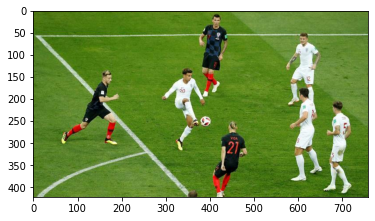

In [3]:
image_path   = "matchimg1.jpg"
pre_image = cv2.imread(image_path)
pre_image = cv2.cvtColor(pre_image, cv2.COLOR_BGR2RGB)
plt.imshow(pre_image)

# Running Custom YOLO 
## (Detects only people and sports-balls)

In [4]:
image,cl = detect_image(yolo, image_path, '', input_size=YOLO_INPUT_SIZE, show=False, rectangle_colors=(255,0,0))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

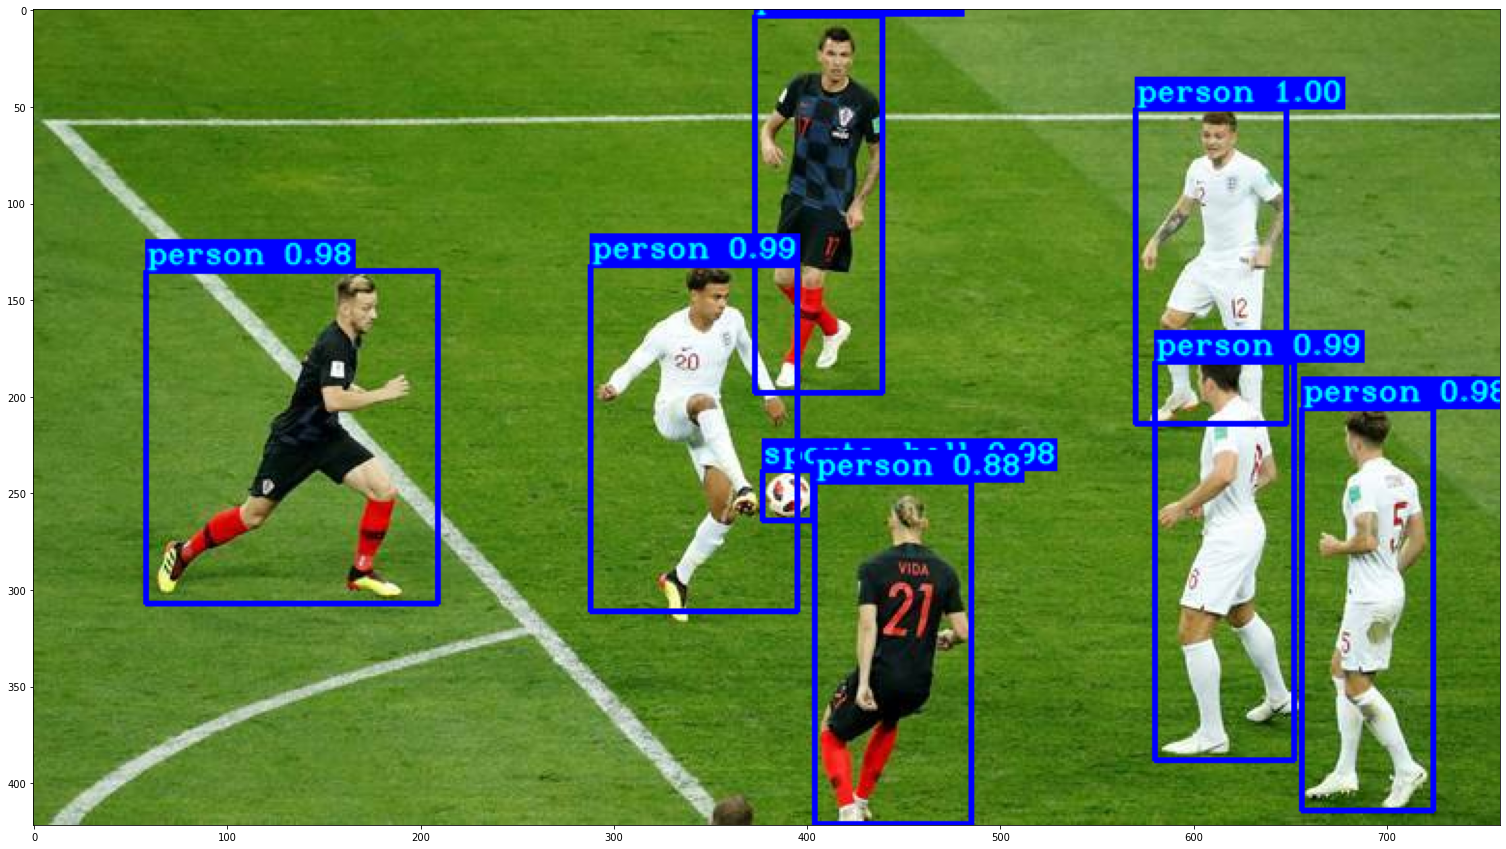

In [5]:
plt.figure(figsize=(30,15))
plt.imshow(image)

# Testing Cl DIctionary returned by YOLO to check access codes

In [6]:
cl

{'sports-ball': [array([377.4241333 , 238.81219482, 403.51446533, 264.17645264,
           0.97933894,  32.        ])],
 'person': [array([570.21472168,  51.25665665, 648.82611084, 214.9229126 ,
           0.99941707,   0.        ]),
  array([373.02496338,   3.84607601, 439.21676636, 198.69113159,
           0.9974938 ,   0.        ]),
  array([288.79077148, 132.62800598, 395.074646  , 311.69369507,
           0.99209374,   0.        ]),
  array([580.4755249 , 182.26361084, 652.59997559, 388.3916626 ,
           0.99038965,   0.        ]),
  array([656.97436523, 206.15402222, 724.47088623, 414.8432312 ,
           0.98498333,   0.        ]),
  array([ 58.9477005 , 135.79945374, 209.38519287, 307.49191284,
           0.98469692,   0.        ]),
  array([404.21789551, 244.88146973, 485.71697998, 421.        ,
           0.88122129,   0.        ])]}

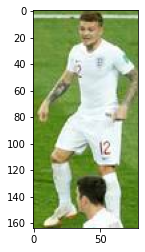

In [7]:
cropped = pre_image[51:215, 570:649]   #[int(1):int(3)+1, int(0):int(2)+1]
plt.imshow(cropped)

In [8]:
for key in cl:
    for val in cl[key]:
        print(val)

[377.4241333  238.81219482 403.51446533 264.17645264   0.97933894
  32.        ]
[570.21472168  51.25665665 648.82611084 214.9229126    0.99941707
   0.        ]
[373.02496338   3.84607601 439.21676636 198.69113159   0.9974938
   0.        ]
[288.79077148 132.62800598 395.074646   311.69369507   0.99209374
   0.        ]
[580.4755249  182.26361084 652.59997559 388.3916626    0.99038965
   0.        ]
[656.97436523 206.15402222 724.47088623 414.8432312    0.98498333
   0.        ]
[ 58.9477005  135.79945374 209.38519287 307.49191284   0.98469692
   0.        ]
[404.21789551 244.88146973 485.71697998 421.           0.88122129
   0.        ]


# Running loop on class to display all objects detected

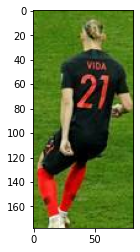

In [9]:
for key in cl:
    for val in cl[key]:
        cropped_image = pre_image[int(val[1]):int(val[3])+1, int(val[0]):int(val[2])+1]
        plt.imshow(cropped_image)

# Running open pose on full image

In [10]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
    

In [11]:
frame = cv2.imread(image_path)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

nPoints = 15
inWidth = frameWidth
inHeight = frameHeight

print(inWidth, inHeight)

759 422


In [12]:
inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

net.setInput(inpBlob)

output = net.forward()
H = output.shape[2]
W = output.shape[3]

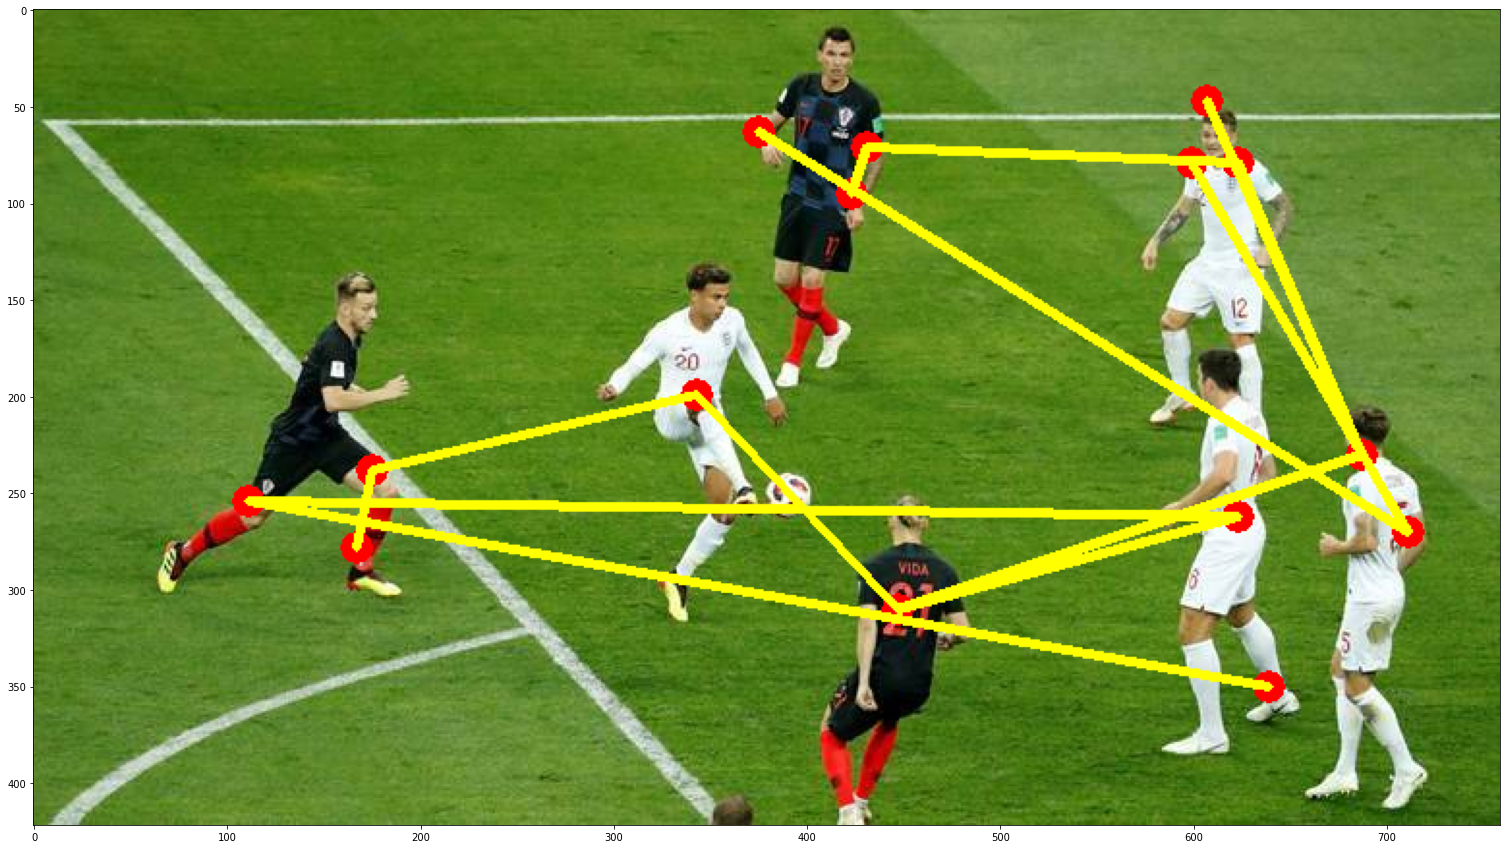

In [13]:
# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)

plt.figure(figsize=(30,15))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Running Open pose on cropped sub sections

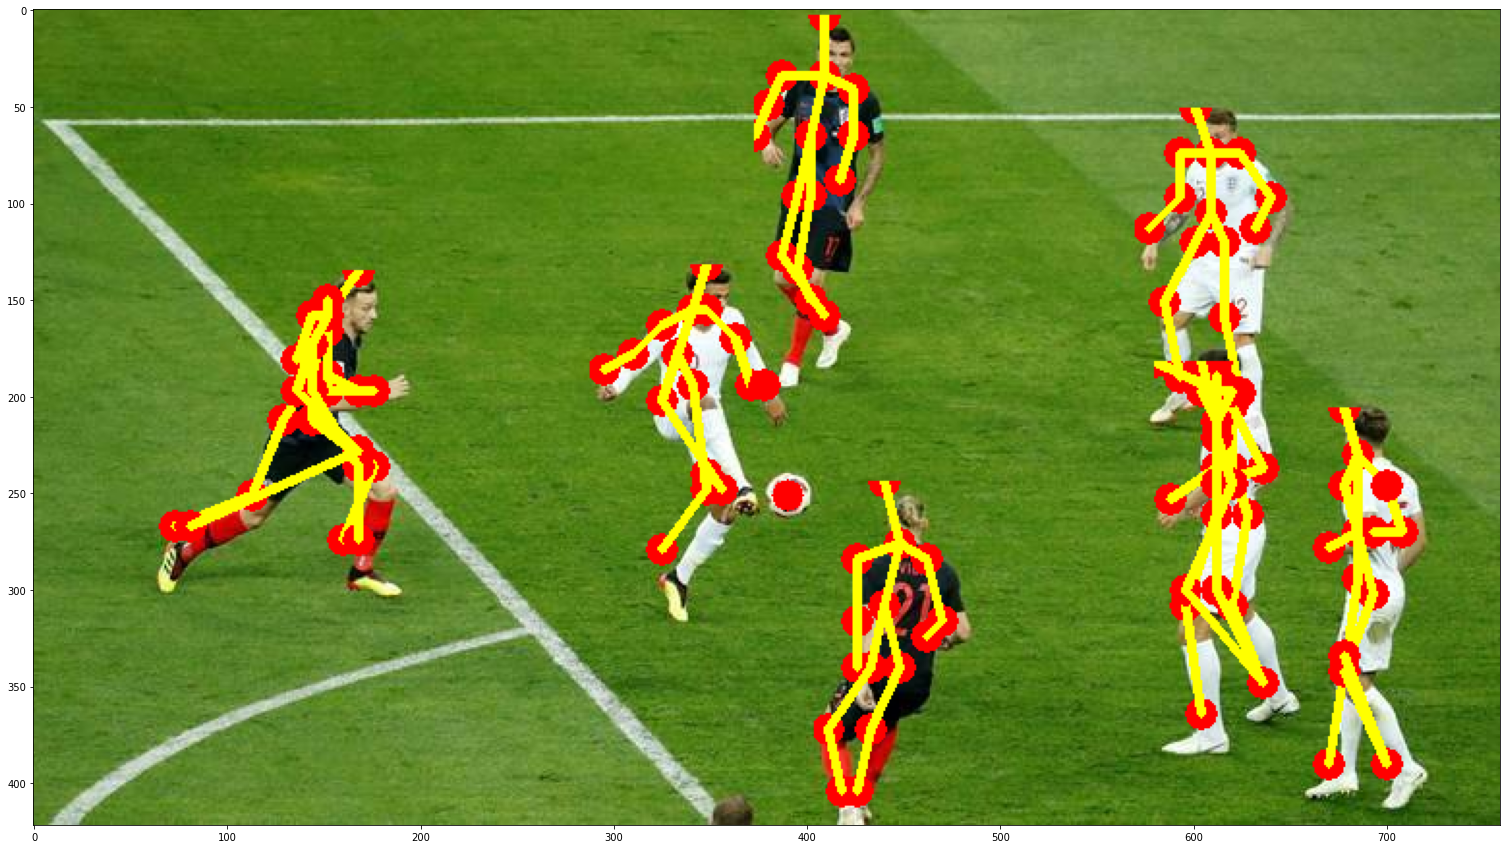

In [14]:
frame = cv2.imread(image_path)
image,cl = detect_image(yolo, image_path, '', input_size=YOLO_INPUT_SIZE, show=False, rectangle_colors=(255,0,0))
ball_x = int((cl['sports-ball'][0][0] + cl['sports-ball'][0][2])/2)
ball_y = int((cl['sports-ball'][0][1] + cl['sports-ball'][0][3])/2)
cv2.circle(frame, (ball_x, ball_y), 0, (0, 0, 255), 15)

player_points = []

#frame = np.copy(image)
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
nPoints = 15
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
for key in cl:
    for val in cl['person']:
        inWidth = int(val[2] - val[0])
        inHeight = int(val[3] - val[1])
        inpBlob = cv2.dnn.blobFromImage(frame[int(val[1]):int(val[3])+1, int(val[0]):int(val[2])+1], 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)
        net.setInput(inpBlob)

        output = net.forward()
        H = output.shape[2]
        W = output.shape[3]
        points = []
        original_points = []
        for i in range(nPoints):
            # confidence map of corresponding body's part.
            probMap = output[0, i, :, :]

            # Find global maxima of the probMap.
            minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

            # Scale the point to fit on the original image
            x = (inWidth * point[0]) / W
            y = (inHeight * point[1]) / H

            if prob > threshold : 
                cv2.circle(frame[int(val[1]):int(val[3])+1, int(val[0]):int(val[2])+1], (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

                # Add the point to the list if the probability is greater than the threshold
                points.append((int(x), int(y)))
            else :
                points.append(None)
        
        player_points.append(points)
        # Draw Skeleton
        for pair in POSE_PAIRS:
            partA = pair[0]
            partB = pair[1]

            if points[partA] and points[partB]:
                cv2.line(frame[int(val[1]):int(val[3])+1, int(val[0]):int(val[2])+1], points[partA], points[partB], (0, 255, 255), 3)

plt.figure(figsize=(30,15))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Find the person closest to the ball, then find the circle closest to the ball, then check if the distance lesser than threshold

### Approach: using bounding box corners, find center of every person,as we have done for the football, calculate distance between ball and every person, note the minimum. Now calculate center distance between center of every circle on that person and the center of ball to find the circle closest to ball. Then check w.r.t threshold.

### Finding Nearest Player

In [15]:
players = []
for val in cl['person']:
    x = int((val[0]+val[2])/2)
    y = int((val[1]+val[3])/2)
    players.append((x,y))

In [16]:
players

[(609, 133),
 (406, 101),
 (341, 222),
 (616, 285),
 (690, 310),
 (134, 221),
 (444, 332)]

In [17]:
ball_dist = []
for player in players:
    distance = np.sqrt(np.square(ball_x - player[0]) + np.square(ball_y - player[1]))
    ball_dist.append(distance)

In [19]:
ball_dist

[248.766959220874,
 150.8509197850646,
 56.938563381947034,
 228.54321254414887,
 305.74662712775756,
 257.75181861628056,
 97.3498844375277]

In [20]:
temp = min(ball_dist) 
idx_min = [i for i, j in enumerate(ball_dist) if j == temp]

In [21]:
idx_min

[2]

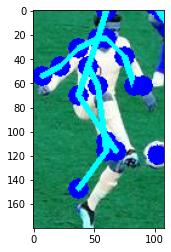

In [22]:
test_print = frame[int(cl['person'][idx_min[0]][1]):int(cl['person'][idx_min[0]][3])+1, int(cl['person'][idx_min[0]][0]):int(cl['person'][idx_min[0]][2])+1]
plt.imshow(test_print)

### Finding nearest point

In [23]:
nearest_player_points = player_points[idx_min[0]]

In [24]:
print(nearest_player_points)

[(60, 0), (53, 23), (37, 31), (22, 46), (7, 54), (60, 23), (75, 38), (83, 62), (37, 70), (68, 116), (60, 108), (53, 62), (60, 116), (37, 147), (45, 46)]


In [25]:
scaled_nearest_player_points = []
for pt in nearest_player_points:
    scale_x = pt[0] + int(cl['person'][idx_min[0]][0])
    scale_y = pt[1] + int(cl['person'][idx_min[0]][1])
    scaled_nearest_player_points.append((scale_x, scale_y))

In [26]:
scaled_nearest_player_points

[(348, 132),
 (341, 155),
 (325, 163),
 (310, 178),
 (295, 186),
 (348, 155),
 (363, 170),
 (371, 194),
 (325, 202),
 (356, 248),
 (348, 240),
 (341, 194),
 (348, 248),
 (325, 279),
 (333, 178)]

In [28]:
#the foot coordinates are idx 12 and 13
leg_1 = scaled_nearest_player_points[12]
leg_2 = scaled_nearest_player_points[13]

In [29]:
print(leg_1, leg_2)

(348, 248) (325, 279)


In [30]:
min_distance = int(min(np.sqrt(np.square(ball_x - leg_1[0]) + np.square(ball_y - leg_1[1])), np.sqrt(np.square(ball_x - leg_2[0]) + np.square(ball_y - leg_2[1]))))

In [31]:
min_distance

42